# Домашнее задание № 5

## по дисциплине: Машинное обучение в бизнесе

### выполнил: Евгений Кириллов

## Задача 1

Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:

    - бустинг
    - логистическая регрессия

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("lesson_5_churn\churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [4]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [5]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [7]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [8]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

### LogisticRegression

In [9]:
pipeline_with_logistic_regression = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=0)),
])

In [10]:
# обучим пайплайн на всем тренировочном датасете
pipeline_with_logistic_regression.fit(X_train, y_train)
y_score = pipeline_with_logistic_regression.predict_proba(X_test)[:, 1]

In [11]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
precision += 0.0001
recall += 0.0001
fscore = (1+b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


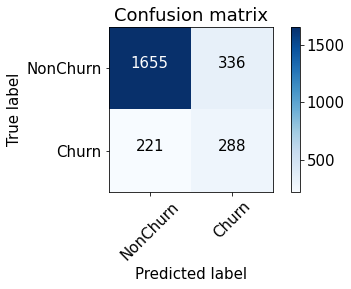

In [13]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [14]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, 
                                               y_score=pipeline_with_logistic_regression.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, 
                                           y_pred=pipeline_with_logistic_regression.predict_proba(X_test)[:,1])))

roc auc score: 0.7720774921330664
log loss score: 0.4267793571344962


In [15]:
logistic_regression_metrics = [fscore[ix], precision[ix], 
                              recall[ix], roc_auc_score(y_true=y_test, 
                                                        y_score=pipeline_with_logistic_regression.predict_proba(X_test)[:,1])]

### GradientBoostingClassifier

In [16]:
pipeline_with_gradient_boosting = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=0)),
])

In [17]:
# обучим пайплайн на всем тренировочном датасете
pipeline_with_gradient_boosting.fit(X_train, y_train)
y_score = pipeline_with_gradient_boosting.predict_proba(X_test)[:, 1]

In [18]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
precision += 0.0001
recall += 0.0001
fscore = (1+b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


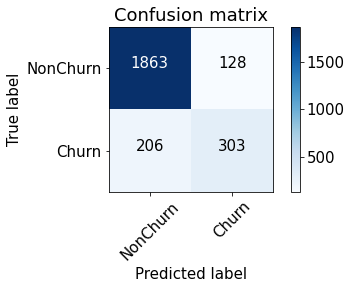

In [19]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [20]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, 
                                               y_score=pipeline_with_gradient_boosting.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, 
                                           y_pred=pipeline_with_gradient_boosting.predict_proba(X_test)[:,1])))

roc auc score: 0.8757527735319746
log loss score: 0.3237020498521011


In [21]:
gradient_boosting_metrics = [fscore[ix], precision[ix], 
                             recall[ix], roc_auc_score(y_true=y_test, 
                                                       y_score=pipeline_with_gradient_boosting.predict_proba(X_test)[:,1])]

## Задача 2

Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)

In [22]:
pd.DataFrame({
    'logistic_regression_metrics': logistic_regression_metrics,
    'gradient_boosting_metrics': gradient_boosting_metrics
}, index=['fscore', 'precision', 'recall', 'roc_auc_score']).transpose()

,fscore,precision,recall,roc_auc_score
logistic_regression_metrics,0.509801,0.462500,0.56788,0.772077
gradient_boosting_metrics,0.646222,0.703804,0.59735,0.875753


очевидно, что gradient boosting показал себя значительно лучше

precision, скорее всего, т.к. она максимизирут прибыль

## Задача 3

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:

    - 1 доллар на удержание
    - 2 доллара - с каждого правильно классифицированного (True Positive)

In [23]:
y_score = pipeline_with_gradient_boosting.predict_proba(X_test)[:, 1]

In [24]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
precision += 0.0001
recall += 0.0001
fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597


### оценка экономической эффективности

In [25]:
tn, fp, fn, tp = confusion_matrix(y_test, y_score > thresholds[ix]).ravel()

In [26]:
spendings_for_retaining_a_client = 1
profit_from_a_retained_client = 2

profit = tp * profit_from_a_retained_client - (tp + fp) * spendings_for_retaining_a_client
profit

175

### мы в плюсе!

## Задача 4

*Провести подбор гиперпараметров лучшей модели по итогам 2-3

pipeline in GridSearchCV nuances - https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline

In [27]:
pipeline_with_gradient_boosting = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(random_state=0)),
])

In [28]:
parameters = {
    "classifier__criterion": ["friedman_mse", "squared_error"],
#     "classifier__loss": ["squared_error", "exponential"],
#     "classifier__max_features": ["log2", "sqrt"],
    "classifier__learning_rate": [0.01, 0.1, 1],
    "classifier__max_depth": [3, 4, 5],
    "classifier__min_samples_leaf": [4, 5, 6],
#     "classifier__subsample": [0.6, 0.7, 0.8],
    "classifier__n_estimators": [10, 50, 100], #number of trees, change it to 1000 for better results
}


In [29]:
%%time
grid = GridSearchCV(estimator=pipeline_with_gradient_boosting,
                    param_grid=parameters,
                    cv=3,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 3min 20s


{'classifier__criterion': 'friedman_mse',
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 4,
 'classifier__min_samples_leaf': 5,
 'classifier__n_estimators': 50}

In [30]:
pipeline_with_gradient_boosting_with_best_params = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier(
        criterion='friedman_mse',
        learning_rate=0.1,
        max_depth=4,
        min_samples_leaf=5,
        n_estimators=50,
        random_state=0)),
])

In [31]:
# обучим пайплайн на всем тренировочном датасете
pipeline_with_gradient_boosting_with_best_params.fit(X_train, y_train)
y_score = pipeline_with_gradient_boosting_with_best_params.predict_proba(X_test)[:, 1]

In [32]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
precision += 0.0001
recall += 0.0001
fscore = (1+b**2) * (precision * recall) / (b**2 * precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.432734, F-Score=0.636, Precision=0.712, Recall=0.574


Confusion matrix, without normalization
[[1873  118]
 [ 218  291]]


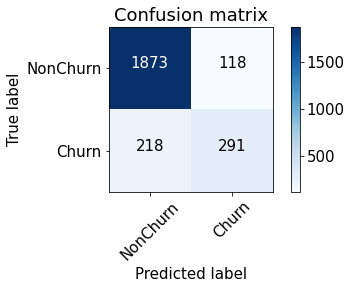

In [33]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

In [34]:
print("roc auc score: {}".format(roc_auc_score(
    y_true=y_test, y_score=pipeline_with_gradient_boosting_with_best_params.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(
    y_true=y_test, y_pred=pipeline_with_gradient_boosting_with_best_params.predict_proba(X_test)[:,1])))

roc auc score: 0.8756432433179169
log loss score: 0.32763523014132895


In [35]:
gradient_boosting_with_best_params_metrics =\
    [fscore[ix], precision[ix], 
     recall[ix], roc_auc_score(y_true=y_test, 
                               y_score=pipeline_with_gradient_boosting_with_best_params.predict_proba(X_test)[:,1])]

In [36]:
pd.DataFrame({
    'logistic_regression_metrics': logistic_regression_metrics,
    'gradient_boosting_metrics': gradient_boosting_metrics,
    'gradient_boosting_with_best_params_metrics': gradient_boosting_with_best_params_metrics
}, index=['fscore', 'precision', 'recall', 'roc_auc_score']).transpose()

,fscore,precision,recall,roc_auc_score
logistic_regression_metrics,0.509801,0.462500,0.567880,0.772077
gradient_boosting_metrics,0.646222,0.703804,0.597350,0.875753
gradient_boosting_with_best_params_metrics,0.635575,0.712295,0.573774,0.875643


## Задача 5

*Еще раз провести оценку экономической эффективности

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, y_score > thresholds[ix]).ravel()

In [38]:
spendings_for_retaining_a_client = 1
profit_from_a_retained_client = 2

profit = tp * profit_from_a_retained_client - (tp + fp) * spendings_for_retaining_a_client
profit

173

мы в плюсе, но меньше, чем в прошлый раз